# Introduction

The object of this project is to explore time series data using Rossmann Sales dataset and related analytical approaches including understanding autocorrelation, seasonal decomposition, SARIMA family models and Facebook Prophet.

The time series anlaysis and forecasting including SARIMA models and Facebook Prophet model are used to forecast daily sales for a month starting from 2015-07-01 to 2015-07-31, as well as the Regression models. Model selection is based on auto-ARIMA process to automatically discover the optimal order for a model. Model performances are evaluated based on Rooted Squared Mean Error.

---

**Project Inspiration:** <br>
https://www.kaggle.com/code/elenapetrova/time-series-analysis-and-forecasts-with-prophet

**Dataset Description**

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

*Data Fields:*

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

[Link to Rossmann Store Sales dataset on Kaggle](https://www.kaggle.com/competitions/rossmann-store-sales)

---



# **Import Libraries and Load Data**

In [1]:
# Data Processing
import numpy as np
import pandas as pd
#pd.set_option('display.float_format', lambda x: '%.8f' % x)

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Modeling
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima # for determining ARIMA orders
from fbprophet import Prophet

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import lightgbm

# Data Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Statistics
from statsmodels.distributions.empirical_distribution import ECDF

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Warning ignore
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')

# **Exploratory Data Analysis**

In [7]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [8]:
# data extraction
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.weekofyear


In [9]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263.0,555.0,1.0,1.0,0,1.0,2015,7,31,31
1,2,5,2015-07-31,6064.0,625.0,1.0,1.0,0,1.0,2015,7,31,31
2,3,5,2015-07-31,8314.0,821.0,1.0,1.0,0,1.0,2015,7,31,31
3,4,5,2015-07-31,13995.0,1498.0,1.0,1.0,0,1.0,2015,7,31,31
4,5,5,2015-07-31,4822.0,559.0,1.0,1.0,0,1.0,2015,7,31,31


**Compute Sales per customer**

* On average, customers spend about $9.5.

In [10]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

print(f"There are {train['SalesPerCustomer'].isnull().sum() / len(train['SalesPerCustomer']) * 100 :.2f}% invalid data (null values).")
train['SalesPerCustomer'].describe()

There are 17.10% invalid data (null values).


count    92929.000000
mean         9.913301
std          2.289460
min          3.016683
25%          8.234609
50%          9.697425
75%         11.393740
max         24.901205
Name: SalesPerCustomer, dtype: float64

**Plot & Read Empirical Cumulative Distribution Function(ECDF) for Sales, Customers & Sales per customer**

* Empirical CDF utilizes the actual data to create a cumulative distribution rather than theoritical distributions.
* ECDF for SalesPerCustomer does not reach 1 as number of observations grows. This is because approximately 17% of data has 0 sales and 0 customers simultaneously in Closed dates, resulting in invalid result values after calculation. Stores could be closed for holidays.

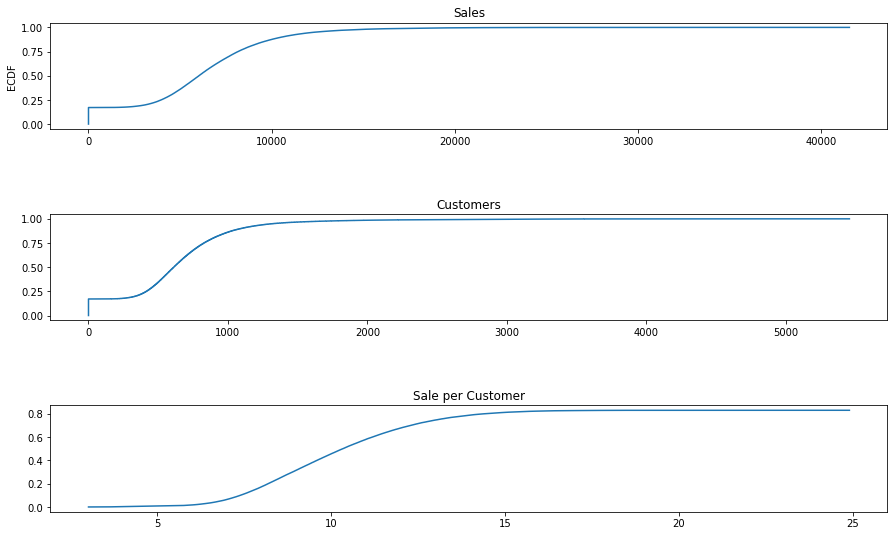

In [11]:
plt.figure(figsize = (15, 9))

plt.subplot(311)

# plot first ECDF
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Customers');

# plot third ECDF  
plt.subplot(313)
cdf = ECDF(train['SalesPerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels");
plt.title('Sale per Customer');
plt.subplots_adjust(hspace = 0.8)

**Explore Store's Open Status and Sales**

* 1105 stores closed 172817 times for State holidaies and school holidaies. 
* 54 stores were opened with zero sales.

In [12]:
print(f"{len(train.query('Open == 0')['Store'].unique())} stores closed {len(train.query('Open == 0'))} times for State holidaies and school holidaies.")

print(f"{len(train.query('Open == 1 & Sales == 0'))} stores were opened with zero sales.")

1098 stores closed 19173 times for State holidaies and school holidaies.
1 stores were opened with zero sales.


In [13]:
# closed stores and days are removed for sales forecasting
df_train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
print(f"Before cleaning: {train.shape[0]}")
print(f"After cleaning: {df_train.shape[0]}")

Before cleaning: 112103
After cleaning: 92929


**Data wrangling in store data set and merge with train set**

In [14]:
print(store.shape)
store.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [15]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

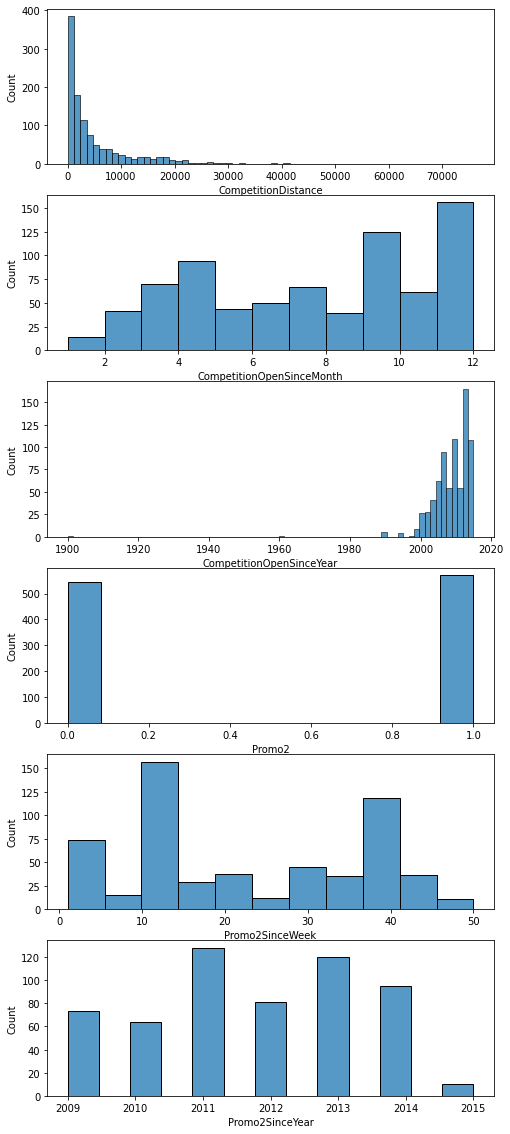

In [16]:
fig, axes = plt.subplots(len(store.drop(columns = ['Store','StoreType','Assortment','PromoInterval']).columns), 1, figsize = (8,20))
for col, ax in zip(store.drop(columns = ['Store','StoreType','Assortment','PromoInterval']).columns, axes.flat):
    sns.histplot(data = store, x = col, ax = ax)


Fill null values in competition distance with a median; fill null values in the rest of features with 0.

In [17]:
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(store['CompetitionDistance'].median())
store = store.fillna(0)

In [18]:
# Merge store set and train set
df_train_store = pd.merge(df_train, store, on = 'Store')
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263.0,555.0,1.0,1.0,0,1.0,2015,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020.0,546.0,1.0,1.0,0,1.0,2015,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782.0,523.0,1.0,1.0,0,1.0,2015,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011.0,560.0,1.0,1.0,0,1.0,2015,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102.0,612.0,1.0,1.0,0,1.0,2015,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


**Explore Store types and Promotions**

Observation:
* Store b has the highest average sales.
* Store b is much less in count among all four types of stores.
* Store a has the most total customers and sales.
* Store b has the least total customers and sales, which is corresponding to the least number in count.

In [19]:
df_train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,50069.0,7124.049492,3273.670002,569.0,4902.0,6501.0,8625.0,41551.0
b,1710.0,11024.246784,5070.214871,1691.0,7143.0,10042.0,13883.0,38484.0
c,12279.0,7106.846730,2698.674093,1153.0,5168.5,6671.0,8573.0,23971.0
d,28871.0,7243.584670,2585.920537,1253.0,5432.0,6810.0,8587.0,30169.0


In [20]:
df_train_store.groupby('StoreType')['Customers','Sales'].sum()

,Customers,Sales
StoreType,,
a,39410758.0,356694034.0
b,3660429.0,18851462.0
c,9806760.0,87264971.0
d,17789216.0,209129533.0


Sales by promotion and store types over time
* With or without promotion, Store type b has the highest sales over months.
* For all store types and promotion status, sales have a drastic increase in **December**.

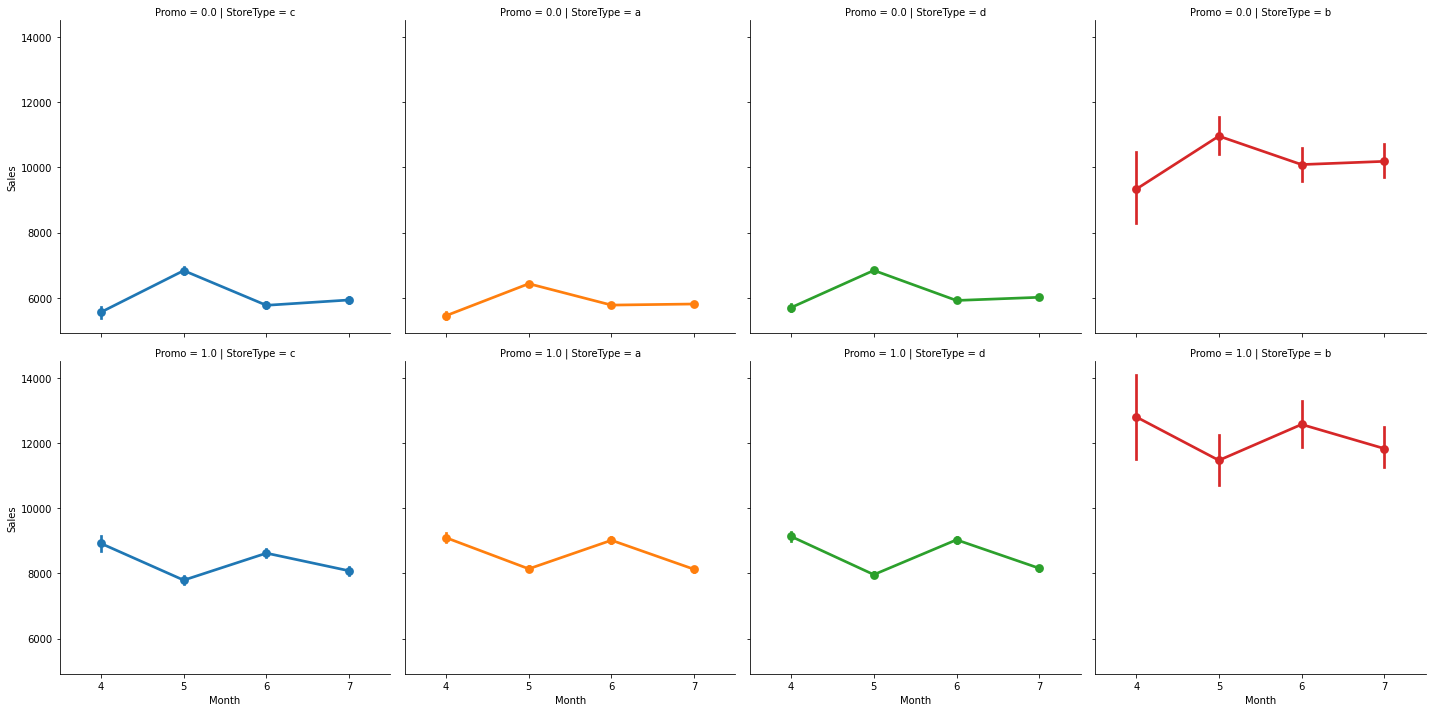

In [21]:
sns.factorplot(
    data = df_train_store,
    x = 'Month', y = 'Sales',
    col = 'StoreType',
    palettele = 'crest',
    hue = 'StoreType',
    row = 'Promo'
)

Sales per customer by store types and proomotion over months

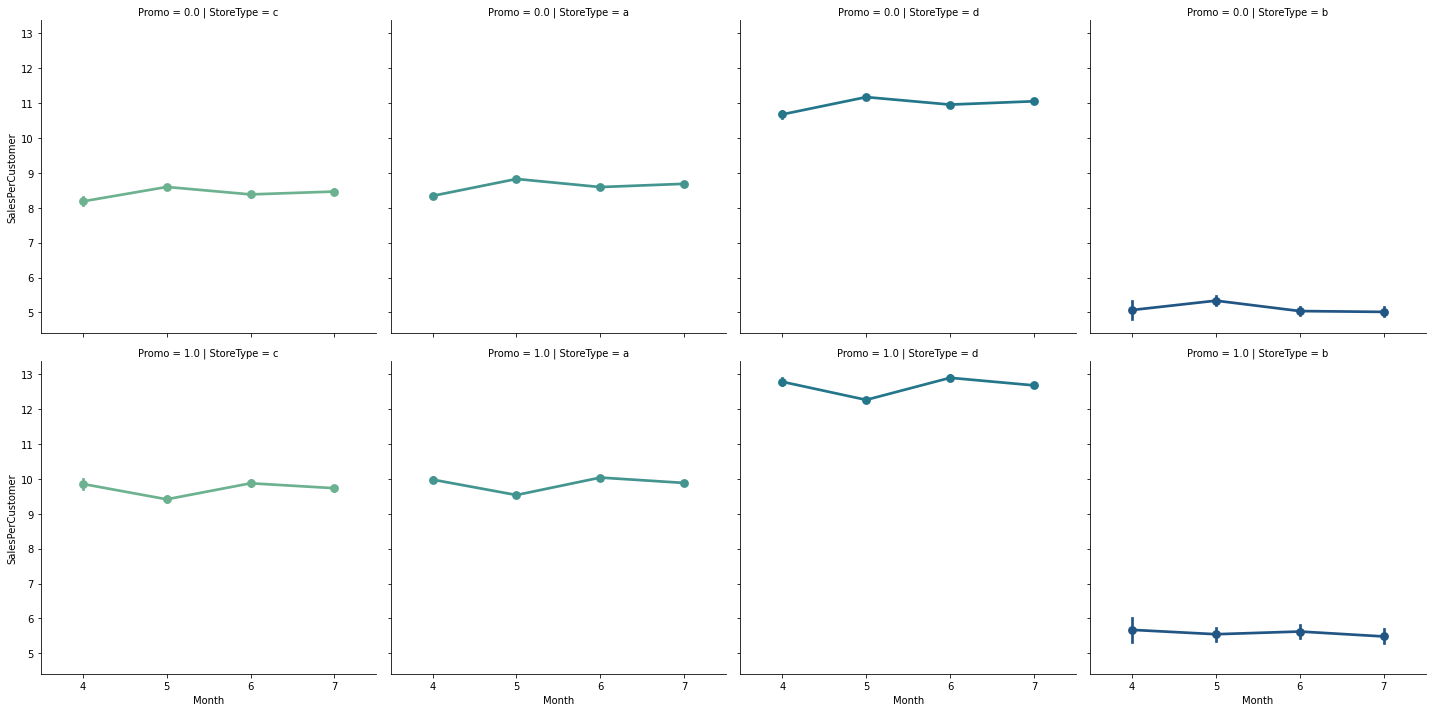

In [22]:
# sale per customer trends
sns.factorplot(data = df_train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'crest',
               hue = 'StoreType',
               row = 'Promo')

Customer traffic by store types and promotion over months

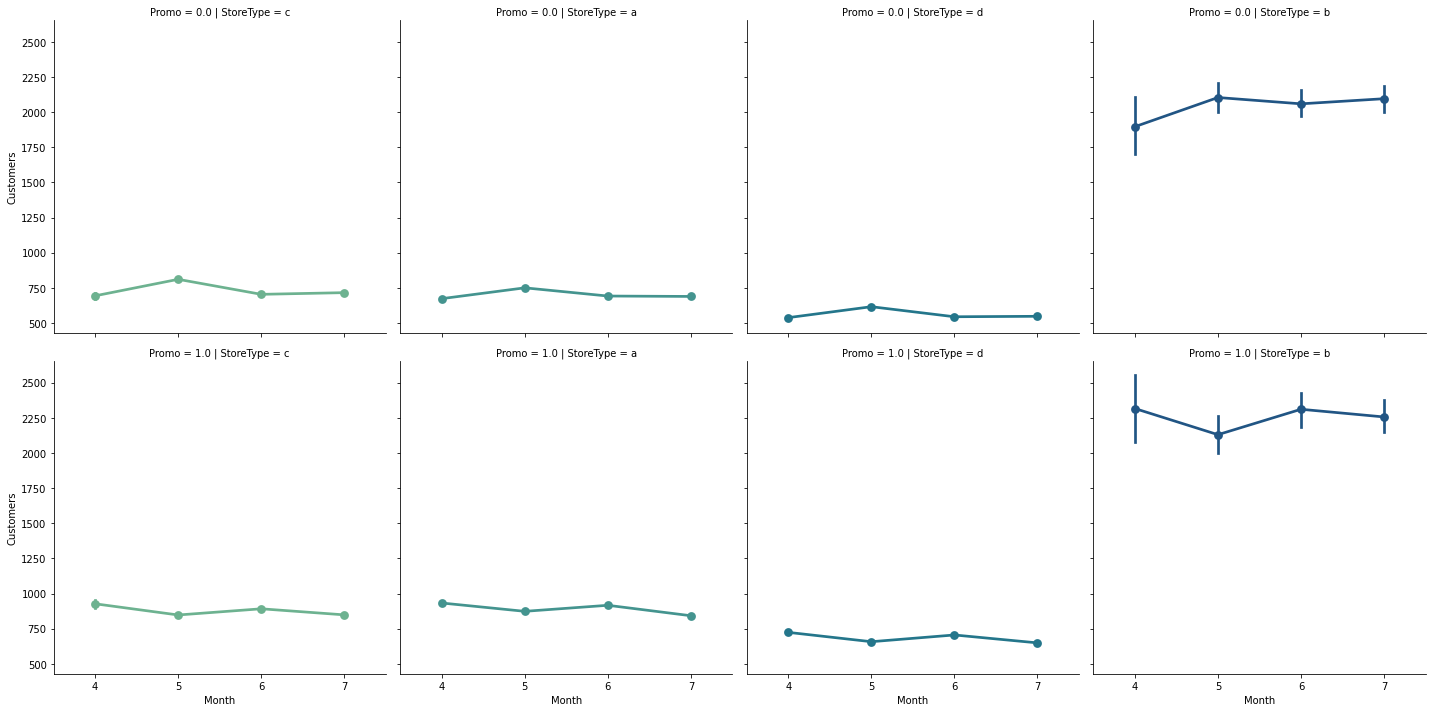

In [23]:
sns.factorplot(data = df_train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'crest',
               hue = 'StoreType',
               row = 'Promo') 

Sales by store types and the day of week over months
* In general, there is less sales on Saturday in each month.
* On Sunday, some stores remain opened while Store type c completely closed businesses.

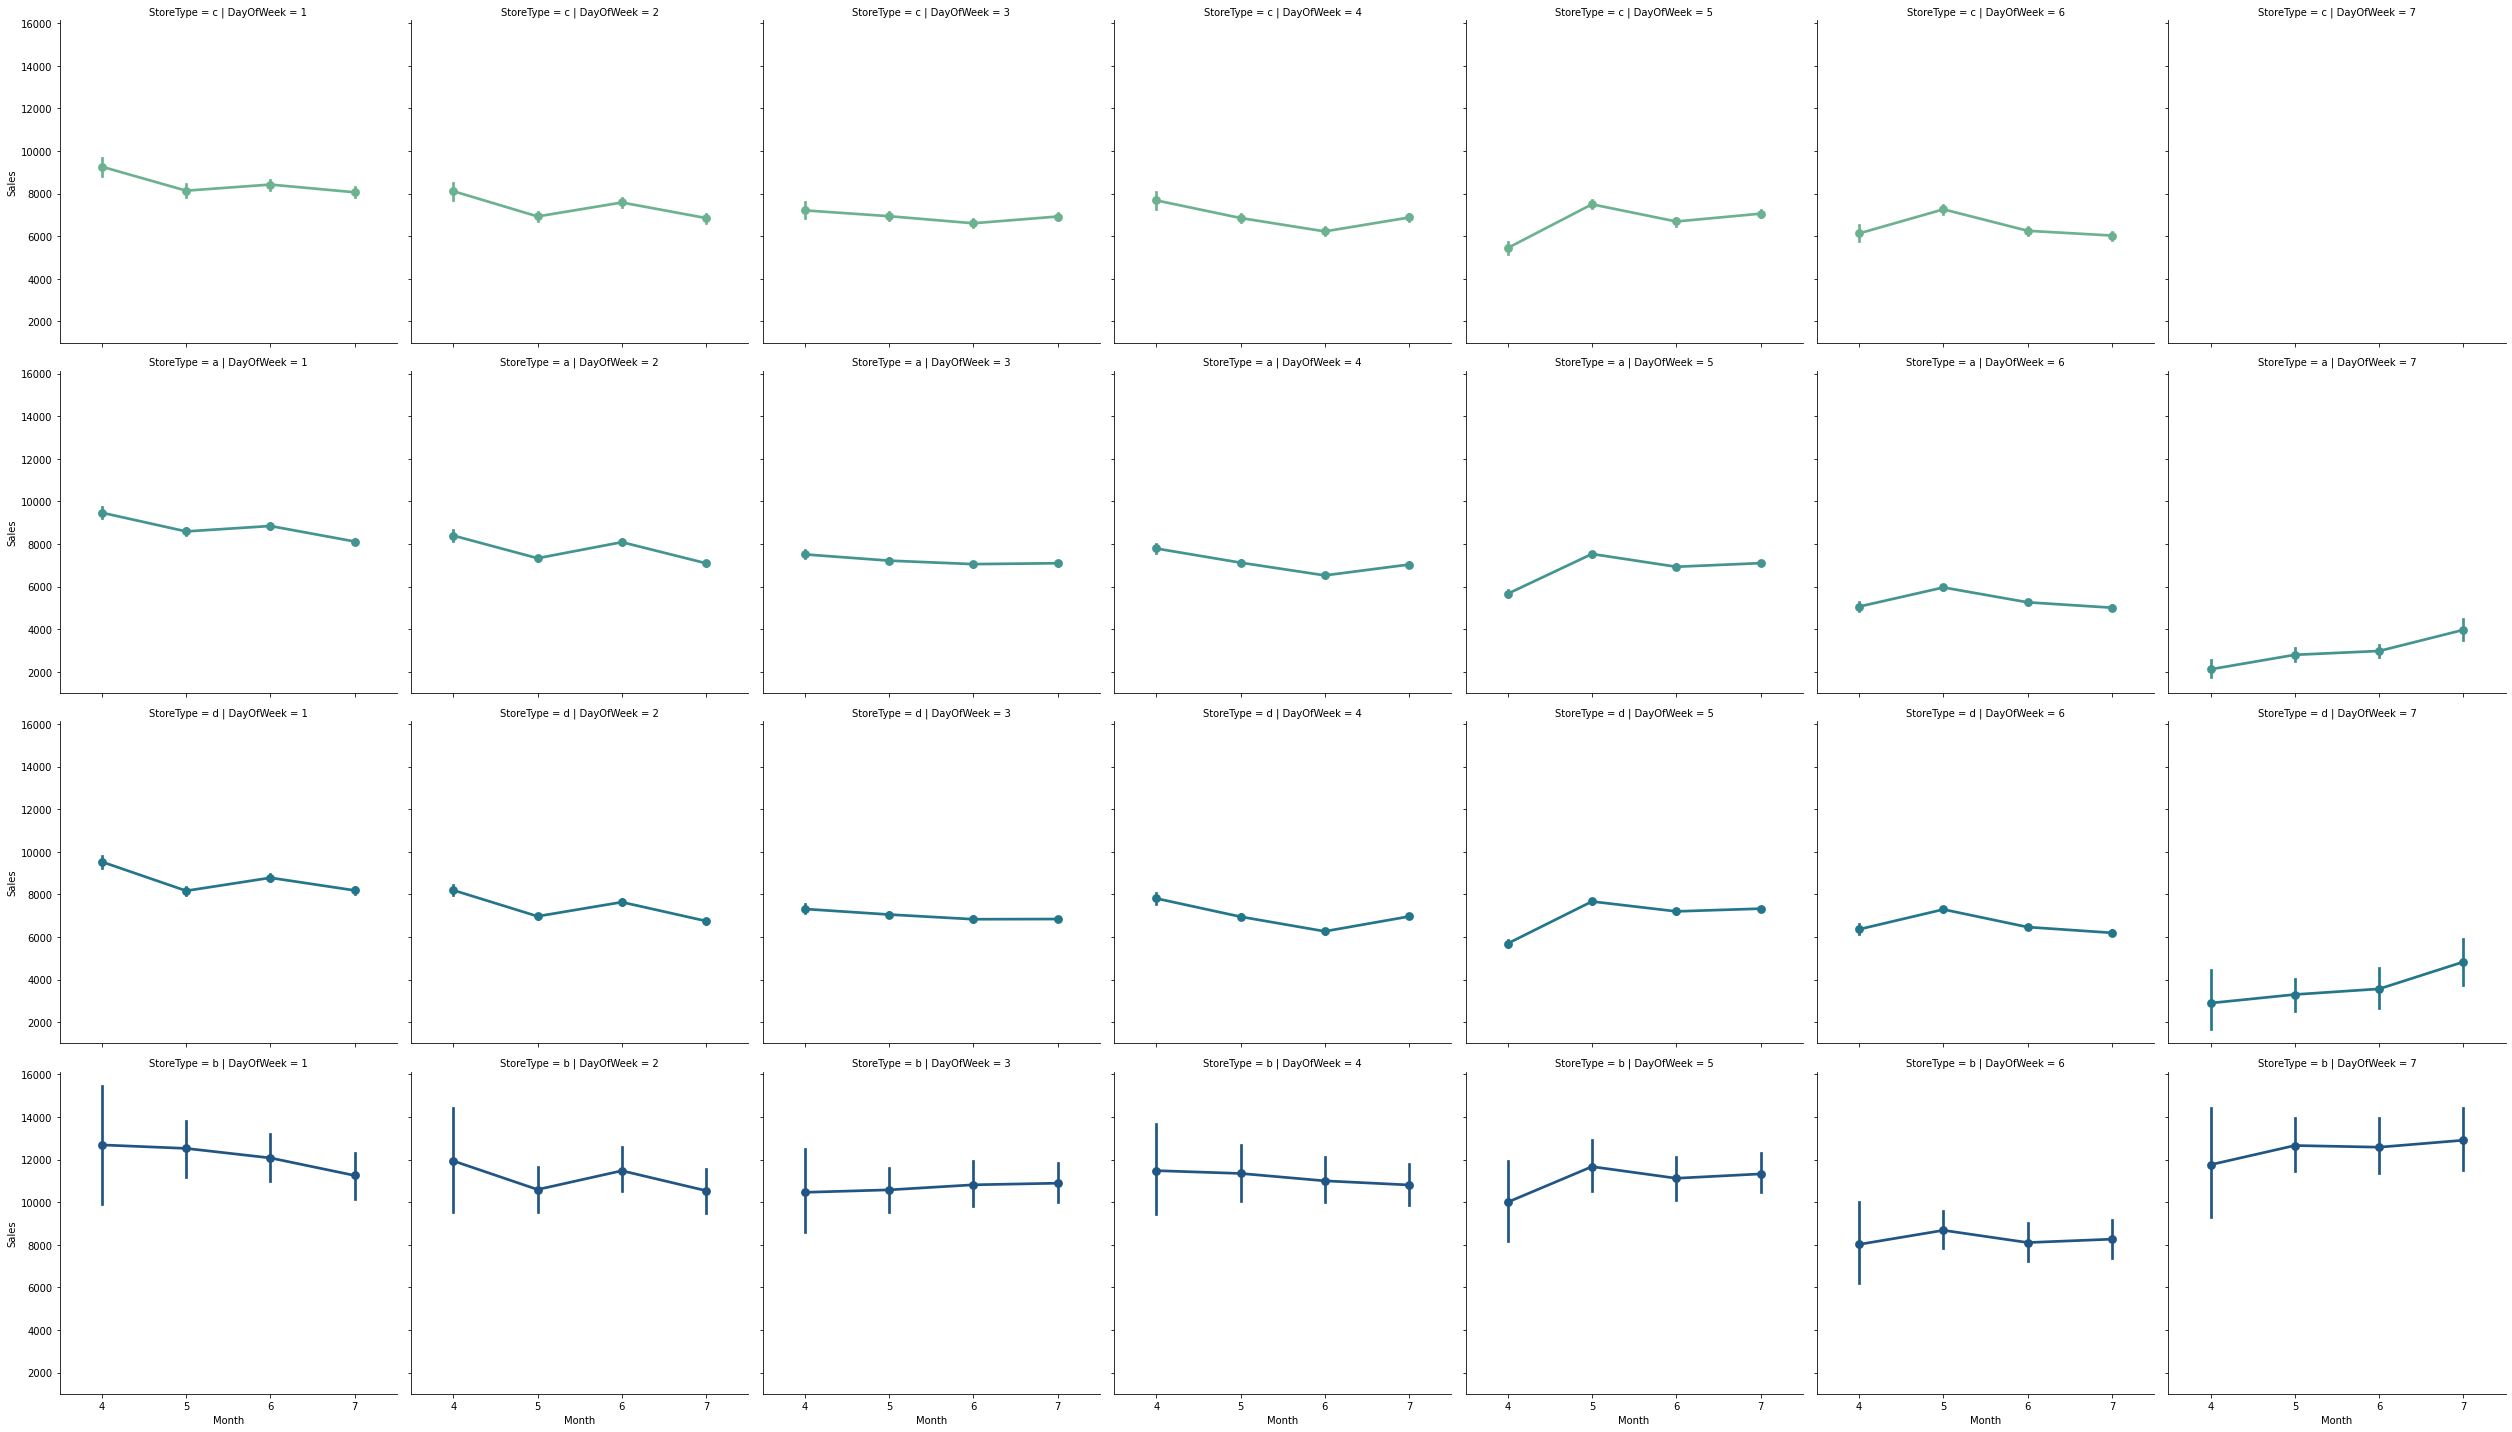

In [24]:
sns.factorplot(data = df_train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'crest',
               hue = 'StoreType',
               row = 'StoreType')

Observation:
* Without either Promo or Promo2, Sales drastically increase on Sunday.
* Stores with Promo generate the most Sales on Monday.
* Promo2 has a little impact on Sales.

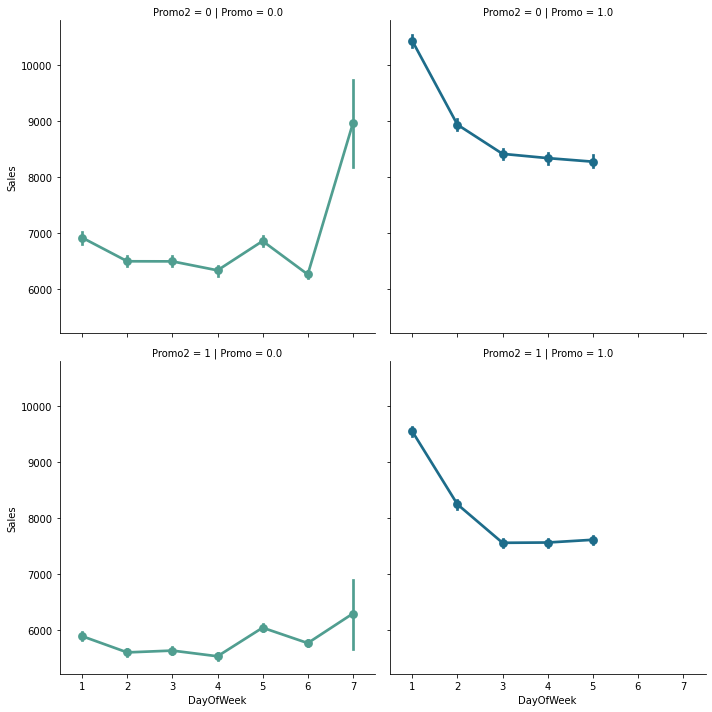

In [25]:
# sale per customer trends
sns.factorplot(data = df_train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               palette = 'crest',
               row = 'Promo2',
               hue = 'Promo'
               ) 

Observation:
* Store type B has the longest running period of promotion on average.
* Store type B has the longest average operation time of competitor stores, thus more local competition.
* Store type B has much lower total sales and customer traffic, than other Store types but generates higher average sales and customer traffic.

In [26]:
# Time (in Months) of a competition store opens
df_train_store['CompetitionOpenMonths'] = 12 * (df_train_store['Year'] - df_train_store['CompetitionOpenSinceYear']) + (df_train_store['Month'] - df_train_store['CompetitionOpenSinceMonth'])

# Time (in Months) of a promotion lasts
df_train_store['PromoOpenMonths'] = 12 * (df_train_store['Year'] - df_train_store['Promo2SinceYear']) + (df_train_store['WeekOfYear'] - df_train_store['Promo2SinceWeek']) / 4

df_train_store[['StoreType','Sales','Customers','CompetitionOpenMonths','PromoOpenMonths']].groupby('StoreType').agg(['sum','mean'])

Sales                 Customers               \
                   sum          mean         sum         mean   
StoreType                                                       
a          356694034.0   7124.049492  39410758.0   787.128922   
b           18851462.0  11024.246784   3660429.0  2140.601754   
c           87264971.0   7106.846730   9806760.0   798.661129   
d          209129533.0   7243.584670  17789216.0   616.162100   

          CompetitionOpenMonths               PromoOpenMonths                
                            sum          mean             sum          mean  
StoreType                                                                    
a                   356189515.0   7113.973017    6.324923e+08  12632.412760  
b                    19571154.0  11445.119298    2.918193e+07  17065.458041  
c                    82863769.0   6748.413470    1.472642e+08  11993.173467  
d                   259339741.0   8982.707249    2.950184e+08  10218.501385

Correlation Matrix

In [27]:
corr = df_train_store.drop(columns = 'Open').corr()

# generate a mask for upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

Correlation Heatmap
* Customers and Sales are highly correlated.
* Promotion and Sales are highly correlated.
* Running preiod of promotion and Sales are moderately correlated.

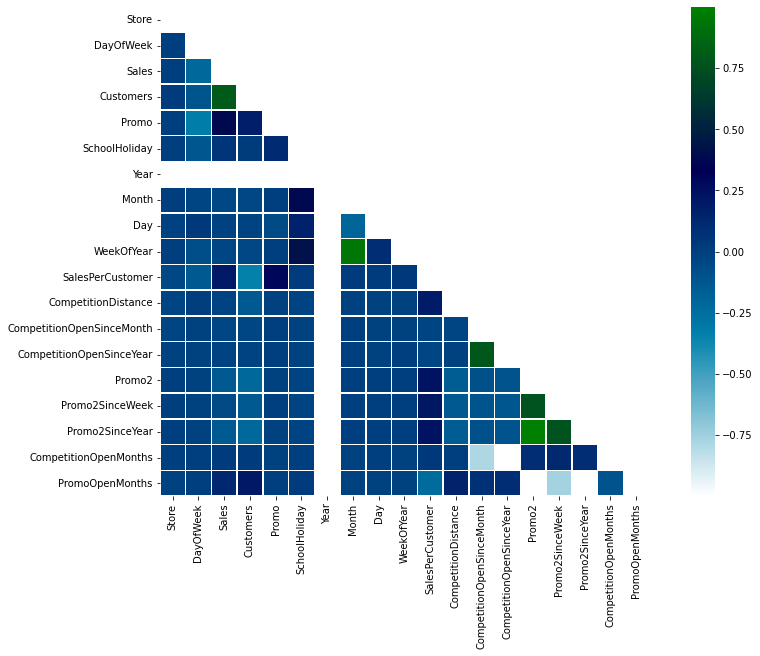

In [28]:
fig, ax = plt.subplots(figsize = (15,9))

sns.heatmap(corr, mask = mask, square = True, linewidths = 0.5, ax = ax, cmap = 'ocean_r')
plt.show()

# **Time Series Analysis**

---

* I will analyze time series data in terms of trends, seasonality, and autocorrelation, to better understand the data.

* To choose the best fitted time series model, for instance, AR, MA, ARMA, ARIMA, I will plot ACF (AutoCorrelation Functioon) and PACF (Partial AutoCorrelation Function) to gain more insights.

**Seasonal decomposition**

Data Wrangling

In [29]:
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}

df_train['StateHoliday'] = df_train['StateHoliday'].replace(mappings).astype('int64')
test['StateHoliday'] = test['StateHoliday'].replace(mappings).astype('int64')

store['StoreType'] = store['StoreType'].replace(mappings).astype('int64')
store['Assortment'] = store['Assortment'].replace(mappings).astype('int64')
store = store.drop(columns = 'PromoInterval')

df_train_store = pd.merge(df_train, store, on = 'Store', how = 'inner')
df_test_store = pd.merge(test, store, on = 'Store', how = 'inner')

I randomly chose Store 5 with Store Type A for time series analysis.

In [30]:
store5_sales = df_train[df_train['Store'] == 5][['Date','Sales','StateHoliday','SchoolHoliday']]
store5_sales['Date'].sort_index(ascending = False, inplace = True) # sort data based on Date and reset index accordingly
store5_sales.shape

(84, 4)

In [31]:
# resample frequency of time series data to a Weekly basis
store5_sales_week = store5_sales.set_index('Date').resample('W').sum()
store5_sales_week

,Sales,StateHoliday,SchoolHoliday
Date,,,
2015-04-26,21747.0,0,4.0
2015-05-03,20212.0,0,4.0
2015-05-10,25429.0,0,5.0
2015-05-17,24445.0,0,2.0
2015-05-24,26104.0,0,0.0
2015-05-31,26186.0,0,0.0
2015-06-07,22782.0,0,0.0
2015-06-14,31203.0,0,0.0
2015-06-21,23801.0,0,0.0


Observation:
* **Trend**: Local trends fluctuate over time and overall trend is stationary.
* **Seasonality**: In generall, there is periodic patterns present in the plot, however, they are not consistent over time.
* **Residual**: The model captures residuals with similar variances.

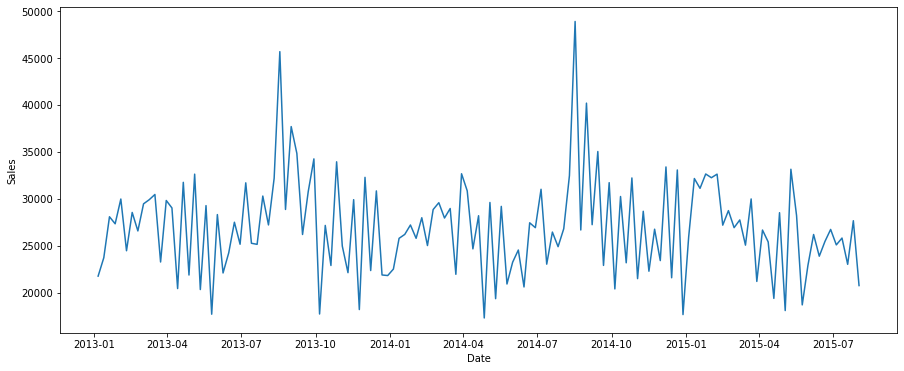

In [ ]:
fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(x = store5_sales_week.index, y = store5_sales_week['Sales'])
plt.show()

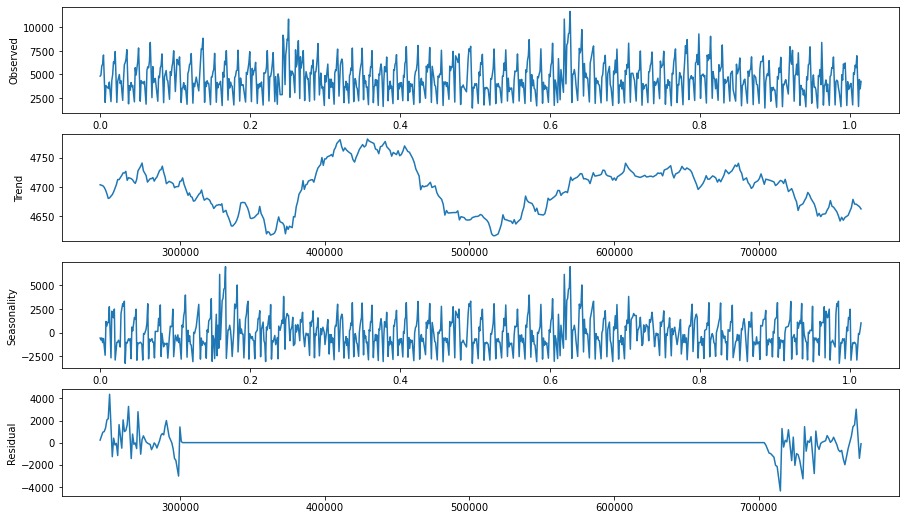

In [ ]:
fig, axes = plt.subplots(4, figsize = (15, 9))

# seasonal decomposition
# additive model: y = level + trend + seasonality + noise
# multiplicative model: y = level * trend * seasonality * noise (non-linear model)
store5_decomposition = seasonal_decompose(store5_sales['Sales'], model = 'additive', freq = 365)

fig1 = store5_decomposition.observed.plot(ax = axes[0])
fig1.set_ylabel("Observed")
fig2 = store5_decomposition.trend.plot(ax = axes[1])
fig2.set_ylabel("Trend")
fig3 = store5_decomposition.seasonal.plot(ax = axes[2])
fig3.set_ylabel("Seasonality")
fig4 = store5_decomposition.resid.plot(ax = axes[3])
fig4.set_ylabel("Residual")
plt.show()


**Autocorrelation & Partial Autocorrelation**

* ACF plot indicates seasonal patterns over time. It shows high positive correlations at lag 12, 24, 36 etc. and high negative correlations at lag 7, 19, 31 etc. For both positive and negative peaks, there is 12-lag difference. Overall, it shows geometric patterns.

* In PACF plot, there is a sharp drop at first 3 lags and discrete lag points that are statistically significant. PACF help us determine the order of autoregressive model.

![image info](https://miro.medium.com/max/1400/1*MJIw0Lh2_PYMKJVTUVWAEw.png)

source: *https://towardsdatascience.com/identifying-ar-and-ma-terms-using-acf-and-pacf-plots-in-time-series-forecasting-ccb9fd073db8*

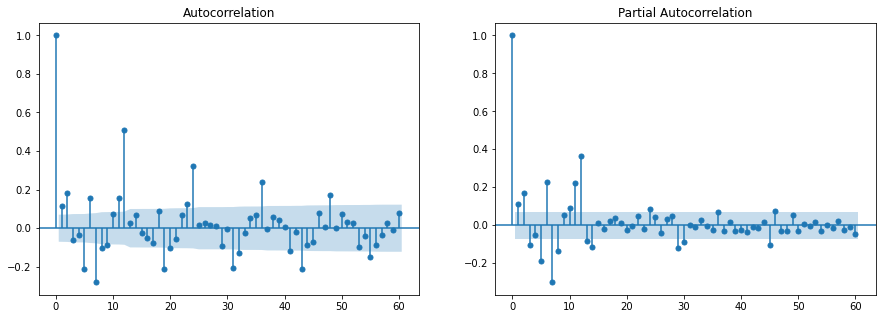

In [ ]:
fig, axes = plt.subplots(1,2, figsize= (15,5))

# plot ACF
plot_acf(store5_sales['Sales'], lags = 60, ax = axes[0])

# plot PACF
plot_pacf(store5_sales['Sales'], lags = 60, ax = axes[1])

plt.show()

**Augmented Dickey-Fuller unit root test**

Interpretation of ADF result:
* p-value is 0.00000096, which is much less than 0.05, indicating that there is strong evidence against the null hypothesis and thus reject the null hypothesis.
* Since null hypothesis is rejected, **the time series has no unit root and is stationary.**

In [ ]:
result_adfuller = adfuller(store5_sales['Sales'].dropna(), autolag = 'AIC')
labels = ['ADF test statistic','p-value','# of lags used',' # of observations used']
output = pd.Series(result_adfuller[0:4], index = labels)
for key, val in result_adfuller[4].items():
    output[f'Critical value for the test statistic at {key} level'] = val

output = output.to_frame()
output.columns = ['value']
output['value'] = output['value'].map('{:,.8f}'.format)
output


,value
ADF test statistic,-5.65677863
p-value,0.00000096
# of lags used,13.00000000
# of observations used,765.00000000
Critical value for the test statistic at 1% level,-3.43892696
Critical value for the test statistic at 5% level,-2.86532549
Critical value for the test statistic at 10% level,-2.56878578


# Time series modeling

**ARIMA Family models**

In [34]:
x = store5_sales.set_index('Date').loc[:'2015-06-30'] # from 2013-1-2 to 2015-6-30
y = store5_sales.set_index('Date').loc['2015-07-01':] # from 2015-7-1 to end of the time

AR model

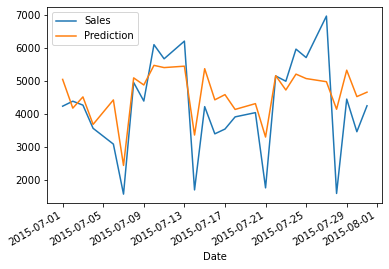

Root Mean Squared Error :  1001.4723365370031


In [ ]:
model_ar = AutoReg(x['Sales'], lags = 13)
ar_fit = model_ar.fit()#(method = 'mle')

start = len(x)
end = len(x) + len(y) - 1
prediction_ar = ar_fit.predict(start = start, end = end, dynamic = False)

prediction_ar.index = y.index

y['Sales'].plot()
prediction_ar.plot(label = 'Prediction')
plt.legend()
plt.show()

print("Root Mean Squared Error : ", np.sqrt(mean_squared_error(y['Sales'], prediction_ar)))

ARMA model

* Result of auto_arima indicates the Auto Regressive order is 5 and Moving Average order is 4.

In [ ]:
# auto_arima automatically discover the optimal order for an ARIMA model.
auto_arima(x['Sales'], seasonal = False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  752
Model:               SARIMAX(5, 0, 4)   Log Likelihood               -6596.646
Date:                Sat, 02 Apr 2022   AIC                          13215.292
Time:                        16:59:28   BIC                          13266.142
Sample:                             0   HQIC                         13234.883
                                - 752                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4576.6387   2037.991      2.246      0.025     582.250    8571.027
ar.L1         -0.6513      0.104     -6.239      0.000      -0.856      -0.447
ar.L2          0.1139      0.168      0.677      0.498      -0.216       0.443
ar.L3          0.6261      0.143      4.376      0.000       0.346       0.907
ar.L4          0.3394      0.078      4.363      0.000       0.187       0.492
ar.L5         -0.4040      0.046     -8.717      0.000      -0.495      -0.313
ma.L1          0.8683      0.112      7.731      0.000       0.648       1.088
ma.L2          0.2773      0.189      1.466      0.143      -0.094       0.648
ma.L3         -0.5114      0.185     -2.767      0.006      -0.874      -0.149
ma.L4         -0.5699      0.100     -5.680      0.000      -0.767      -0.373
sigma2      2.515e+06   1.36e+05     18.554      0.000    2.25e+06    2.78e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.64
Prob(Q):                              0.92   Prob(JB):                         0.16
Heteroskedasticity (H):               1.03   Skew:                            -0.07
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.59e+14. Standard errors may be unstable.
"""

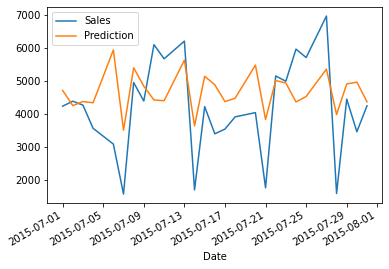

Root Mean Squared Error :  1320.744705380822


In [ ]:
model_arma = ARMA(x['Sales'], order = (5,4))
arma_fit = model_arma.fit()

start = len(x)
end = len(x) + len(y) - 1

prediction_arma = arma_fit.predict(start = start, end = end, dynamic = False)
prediction_arma.index = y.index

y['Sales'].plot()
prediction_arma.plot(label = 'Prediction')
plt.legend()
plt.show()

print("Root Mean Squared Error : ", np.sqrt(mean_squared_error(y['Sales'], prediction_arma)))

**Explore impacts of holidays in ARMA model**

In [ ]:
auto_arima(x['Sales'], exorgenous = [['SchoolHoliday','StateHoliday']], seasonal = False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  752
Model:               SARIMAX(5, 0, 4)   Log Likelihood               -6596.646
Date:                Sat, 02 Apr 2022   AIC                          13215.292
Time:                        16:59:46   BIC                          13266.142
Sample:                             0   HQIC                         13234.883
                                - 752                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4576.6387   2037.991      2.246      0.025     582.250    8571.027
ar.L1         -0.6513      0.104     -6.239      0.000      -0.856      -0.447
ar.L2          0.1139      0.168      0.677      0.498      -0.216       0.443
ar.L3          0.6261      0.143      4.376      0.000       0.346       0.907
ar.L4          0.3394      0.078      4.363      0.000       0.187       0.492
ar.L5         -0.4040      0.046     -8.717      0.000      -0.495      -0.313
ma.L1          0.8683      0.112      7.731      0.000       0.648       1.088
ma.L2          0.2773      0.189      1.466      0.143      -0.094       0.648
ma.L3         -0.5114      0.185     -2.767      0.006      -0.874      -0.149
ma.L4         -0.5699      0.100     -5.680      0.000      -0.767      -0.373
sigma2      2.515e+06   1.36e+05     18.554      0.000    2.25e+06    2.78e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.64
Prob(Q):                              0.92   Prob(JB):                         0.16
Heteroskedasticity (H):               1.03   Skew:                            -0.07
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.59e+14. Standard errors may be unstable.
"""

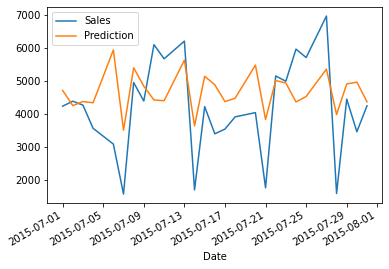

Root Mean Squared Error :  1320.744705380822


In [ ]:
model_arma_exog = ARMA(x['Sales'], order = (5,4))
arma_exog_fit = model_arma_exog.fit()

start = len(x)
end = len(x) + len(y) - 1

exogs = x[['StateHoliday','SchoolHoliday']]
prediction_arma_exog = arma_exog_fit.predict(start = start, end = end, exog = exogs, dynamic = False)
prediction_arma_exog.index = y.index

y['Sales'].plot()
prediction_arma_exog.plot(label = 'Prediction')
plt.legend()
plt.show()

print("Root Mean Squared Error : ", np.sqrt(mean_squared_error(y['Sales'], prediction_arma_exog)))

SARIMA model - Explore impact of seasonality
* SARIMA takes seasonality into consideration.
* m is the number of periods in each season.
    * 1 (annual/non-seasonal data)
    * 4 (quarterly data)
    * 7 (daily data)
    * 12 (monthly data)
    * 52 (weekly data).

* *Different m, thus orders, will be tested and compared for performance.*

In [ ]:
# Explore daily seasonality
auto_arima(x['Sales'], seasonal = True, m = 7).summary() # daily

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  752
Model:             SARIMAX(5, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -6597.787
Date:                             Sat, 02 Apr 2022   AIC                          13219.573
Time:                                     17:03:11   BIC                          13275.046
Sample:                                          0   HQIC                         13240.946
                                             - 752                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5919.8175   1.15e+04      0.515      0.607   -1.66e+04    2.85e+04
ar.L1         -1.3772      0.080    -17.294      0.000      -1.533      -1.221
ar.L2         -1.0006      0.092    -10.837      0.000      -1.182      -0.820
ar.L3         -0.2012      0.076     -2.653      0.008      -0.350      -0.053
ar.L4          0.1966      0.080      2.464      0.014       0.040       0.353
ar.L5         -0.1451      0.058     -2.505      0.012      -0.259      -0.032
ma.L1          1.5985      0.066     24.145      0.000       1.469       1.728
ma.L2          1.5198      0.073     20.683      0.000       1.376       1.664
ma.L3          0.6822      0.056     12.272      0.000       0.573       0.791
ar.S.L7        0.6423      0.694      0.925      0.355      -0.718       2.003
ma.S.L7       -0.6691      0.669     -1.000      0.317      -1.980       0.642
sigma2      2.587e+06   1.43e+05     18.084      0.000    2.31e+06    2.87e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.26
Prob(Q):                              0.99   Prob(JB):                         0.32
Heteroskedasticity (H):               1.04   Skew:                             0.01
Prob(H) (two-sided):                  0.78   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.04e+14. Standard errors may be unstable.
"""

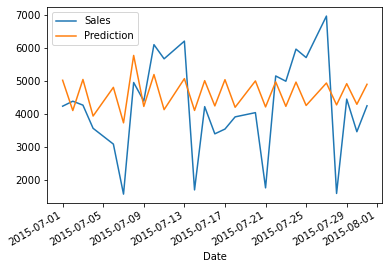

Root Mean Squared Error :  1322.7335939904833


In [ ]:
model_sarima = SARIMAX(x['Sales'], order = (5,0,3), seasonal_order = (1,0,1,7))
sarima_fit = model_sarima.fit()

start = len(x)
end = len(x) + len(y) - 1

prediction_sarima = sarima_fit.predict(start = start, end = end, dynamic = False)
prediction_sarima.index = y.index

y['Sales'].plot()
prediction_sarima.plot(label = 'Prediction')
plt.legend()
plt.show()

print("Root Mean Squared Error : ", np.sqrt(mean_squared_error(y['Sales'], prediction_sarima)))

In [ ]:
auto_arima(x['Sales'], seasonal = True, m = 52).summary() # weekly

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  752
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 52)   Log Likelihood               -6655.998
Date:                            Sat, 02 Apr 2022   AIC                          13325.996
Time:                                    17:15:12   BIC                          13358.355
Sample:                                         0   HQIC                         13338.463
                                            - 752                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3802.1104   2.77e+04      0.137      0.891   -5.05e+04    5.81e+04
ar.L1         -0.7155      0.043    -16.636      0.000      -0.800      -0.631
ar.L2          0.2436      0.036      6.788      0.000       0.173       0.314
ma.L1          0.8822      0.030     29.056      0.000       0.823       0.942
ar.S.L52       0.4495      4.008      0.112      0.911      -7.406       8.305
ma.S.L52      -0.4414      4.023     -0.110      0.913      -8.327       7.444
sigma2      2.998e+06   1.72e+05     17.409      0.000    2.66e+06    3.34e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.90   Prob(JB):                         0.88
Heteroskedasticity (H):               0.98   Skew:                            -0.00
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

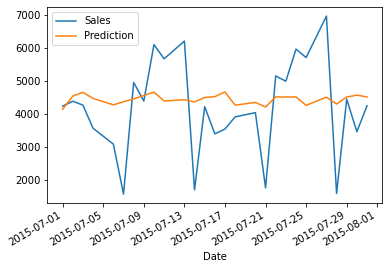

Root Mean Squared Error :  1402.2164320238032


In [ ]:
model_sarima2 = SARIMAX(x['Sales'], order = (2,0,1), seasonal_order = (1,0,1,52))
sarima_fit2 = model_sarima2.fit()

start = len(x)
end = len(x) + len(y) - 1

prediction_sarima2 = sarima_fit2.predict(start = start, end = end, dynamic = False)
prediction_sarima2.index = y.index

y['Sales'].plot()
prediction_sarima2.plot(label = 'Prediction')
plt.legend()
plt.show()

print("Root Mean Squared Error : ", np.sqrt(mean_squared_error(y['Sales'], prediction_sarima2)))

**Facebook Prophet forecasting model**

In [101]:
state_holiday = x[x['StateHoliday'] == 1].reset_index()['Date'].values
school_holiday = x[x['SchoolHoliday'] == 1].reset_index()['Date'].values

df_stateholiday = pd.DataFrame()
df_stateholiday['ds'] = pd.to_datetime(state_holiday) # standard format
df_stateholiday['holiday'] = 'State_holiday' # standard format

df_schoolholiday = pd.DataFrame()
df_schoolholiday['ds'] = pd.to_datetime(school_holiday) # standard format
df_schoolholiday['holiday'] = 'School_holiday' # standard format

df_holiday = pd.concat((df_stateholiday,df_schoolholiday))
# df_holiday

In [102]:
fb_train = x.reset_index()[['Date','Sales']]
fb_train.columns = ['ds','y'] # standard format

# https://facebook.github.io/prophet/docs/uncertainty_intervals.html
fb_model = Prophet(interval_width= 0.95, holidays = df_holiday)

fb_model.fit(fb_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [103]:
future = fb_model.make_future_dataframe(periods = 31)

forecast = fb_model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,School_holiday,School_holiday_lower,School_holiday_upper,State_holiday,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
83,2015-07-27,5199.300589,3321.524794,8797.128665,5199.300417,5199.300745,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,797.177620,797.177620,797.177620,0.0,0.0,0.0,5996.478209
84,2015-07-28,5228.571848,3320.343906,8960.181678,5228.571668,5228.572011,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,999.351548,999.351548,999.351548,0.0,0.0,0.0,6227.923396
85,2015-07-29,5257.843107,3171.850196,8776.165920,5257.842920,5257.843279,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,792.972126,792.972126,792.972126,0.0,0.0,0.0,6050.815232
86,2015-07-30,5287.114366,3908.315328,9487.301533,5287.114170,5287.114550,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1339.907219,1339.907219,1339.907219,0.0,0.0,0.0,6627.021585
87,2015-07-31,5316.385625,2134.658083,7575.792353,5316.385425,5316.385816,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-457.511549,-457.511549,-457.511549,0.0,0.0,0.0,4858.874076


In [104]:
df_forecast = forecast[['ds','yhat']]
df_actual = y['Sales'].reset_index()
outcome = df_forecast.set_index('ds').join(df_actual.set_index('Date')).dropna()
outcome.rename(columns = {'Sales':'y'}, inplace = True)
outcome.reset_index(inplace = True)

Root Mean Squared Error: 1913.2079232411772


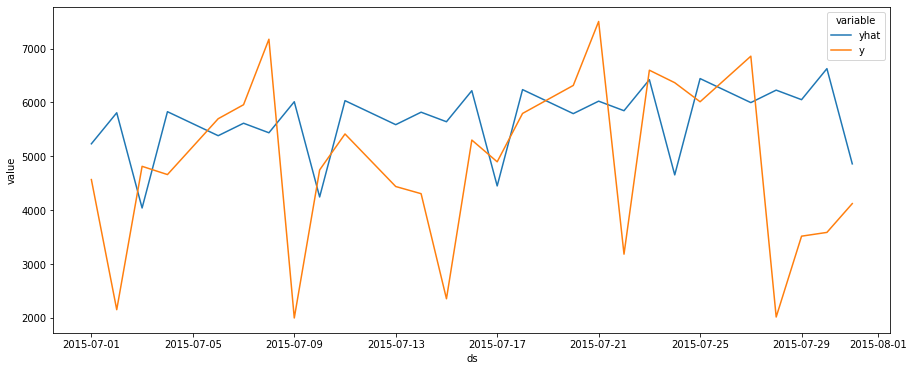

In [105]:
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(outcome['y'] , outcome['yhat'])))

fig, ax = plt.subplots(figsize = (15,6))
sns.lineplot(data = pd.melt(outcome,'ds'), x = 'ds', y = 'value', hue = 'variable')
plt.show()

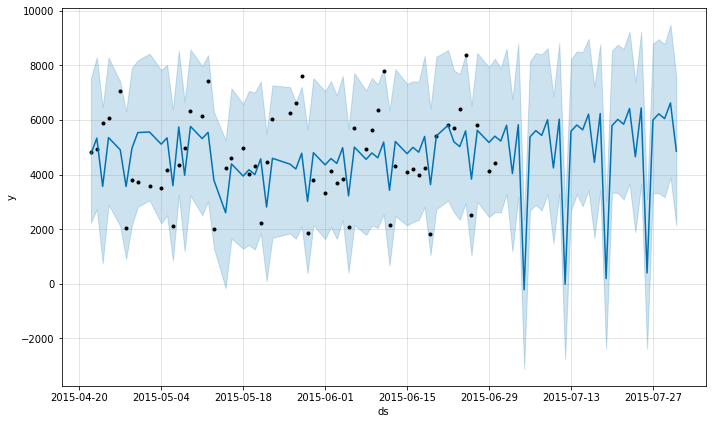

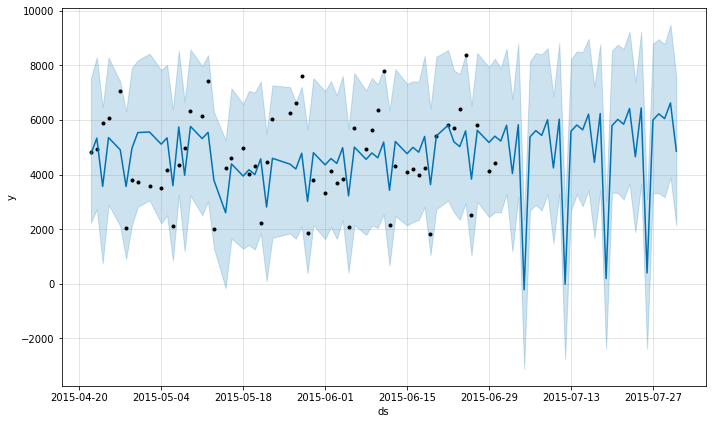

In [112]:
# https://facebook.github.io/prophet/docs/quick_start.html
# from prophet.plot import plot_plotly, plot_components_plotly
# plot_plotly(fb_model, forecast)
fb_model.plot(forecast)

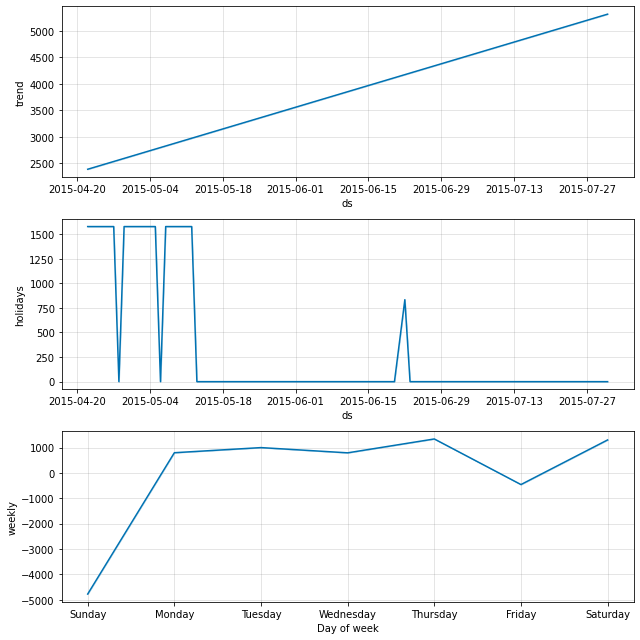

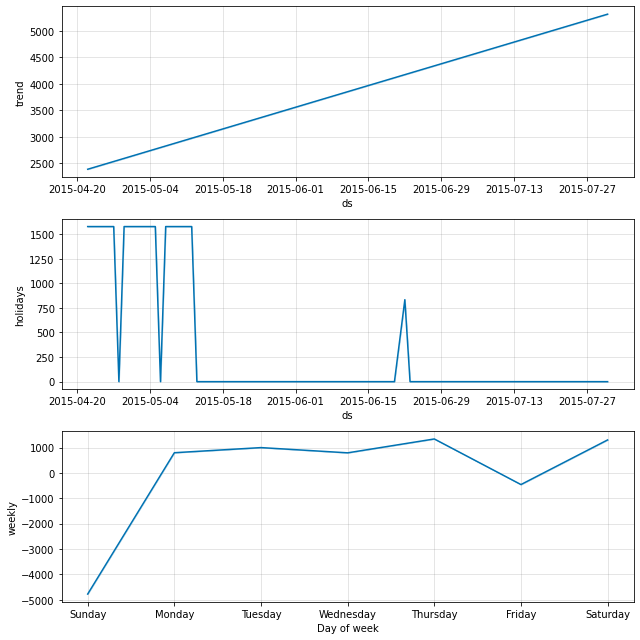

In [113]:
fb_model.plot_components(forecast)

# Regression Model Predictions

In [ ]:
def model_evaluation(model_name, y_test , pred):
  print(model_name)
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test , pred)))
  print('Mean Absolute Percent Error:', mean_absolute_percentage_error(y_test ,pred))
  print('\n')

In [ ]:
df_train_store['Date'].sort_index(ascending=False, inplace = True) # solve reverse order in date

df_train_store = df_train_store.drop(columns = ['Open','Assortment','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear'])

In [ ]:
# create regression models
# n_jobs is set to 1 if default is None for maximum efficiency
lr = LinearRegression(n_jobs = -1)
rf = RandomForestRegressor(random_state=12, n_jobs = -1)
lasso = Lasso(random_state=12)
ridge = Ridge(random_state=12)
gradientboost = GradientBoostingRegressor(random_state=12)
xgboost = XGBRegressor(random_state=12)
# https://neptune.ai/blog/xgboost-vs-lightgbm#:~:text=In%20XGBoost%2C%20trees%20grow%20depth,difference%20between%20the%20two%20frameworks.
lgbm = LGBMRegressor(random_state=12)

**Explore regression models on the entire dataset**

In [ ]:
# apply the same date range as time series analysis
train_regression = df_train_store.set_index('Date').loc[:'2015-06-30']
test_regression  = df_train_store.set_index('Date').loc['2015-07-01':]

x_train = train_regression.drop(columns = ['Store','Sales','Customers','SalesPerCustomer'])
y_train = train_regression['Sales']
x_test = test_regression.drop(columns=['Store','Sales','Customers','SalesPerCustomer'])
y_test = test_regression['Sales']

In [ ]:
models = [lr, rf, lasso, ridge, gradientboost, xgboost, lgbm]

for model in models:
    name = model.__class__.__name__ # model.__name__
    
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    model_evaluation(name, y_test, y_pred)



LinearRegression
Root Mean Squared Error: 2750.6133071197414
Mean Absolute Percent Error: 0.33689766015565054


RandomForestRegressor
Root Mean Squared Error: 2030.5860544007874
Mean Absolute Percent Error: 0.19217952741800726


Lasso
Root Mean Squared Error: 2750.5221951051594
Mean Absolute Percent Error: 0.33692281100356614


Ridge
Root Mean Squared Error: 2750.6130150143986
Mean Absolute Percent Error: 0.33689769795326585


GradientBoostingRegressor
Root Mean Squared Error: 2471.9087804975566
Mean Absolute Percent Error: 0.30234524541564795


XGBRegressor
Root Mean Squared Error: 1707.0622220256257
Mean Absolute Percent Error: 0.1929770102355242


LGBMRegressor
Root Mean Squared Error: 2141.260478167009
Mean Absolute Percent Error: 0.2625346977210424




Observation:
* XGBoost model has the best performance.
* XGBoost model's variable importances indicate that Competition distance, Day of Week and Store Type are 3 the most important factors on sales.
* Random Forest model, with the second best performance, suggests that Competition distance, Promotion status and Store Type are the top 3 influencing factors.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

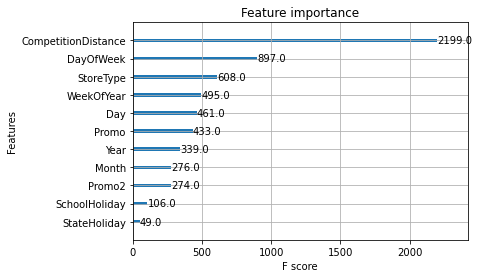

In [ ]:
# explore the result of XGBoost model
xgb.plot_importance(xgboost)

In [ ]:
# explore the result of Random Forest model
pd.Series(data = rf.feature_importances_, index = x_train.columns).sort_values(ascending = False)

CompetitionDistance    0.489099
Promo                  0.148978
StoreType              0.075775
DayOfWeek              0.075539
Day                    0.069231
WeekOfYear             0.053316
Month                  0.027731
Promo2                 0.022312
Year                   0.021751
SchoolHoliday          0.014608
StateHoliday           0.001660
dtype: float64

**Explore Regression models on Store 5**

In [ ]:
# apply the same date range as time series analysis
train_regression_store5 = df_train_store.query("Store == 5").set_index('Date').loc[:'2015-06-30']
test_regression_store5  = df_train_store.query("Store == 5").set_index('Date').loc['2015-07-01':]

x_train_store5 = train_regression_store5.drop(columns = ['Store','Sales','Customers','SalesPerCustomer'])
y_train_store5 = train_regression_store5['Sales']
x_test_store5 = test_regression_store5.drop(columns=['Store','Sales','Customers','SalesPerCustomer'])
y_test_store5 = test_regression_store5['Sales']

In [ ]:
for model in models:
    name = model.__class__.__name__ # model.__name__
    
    model.fit(x_train_store5,y_train_store5)
    y_pred = model.predict(x_test_store5)

    model_evaluation(name, y_test_store5, y_pred)

LinearRegression
Root Mean Squared Error: 952.5786343212186
Mean Absolute Percent Error: 0.21161269244388115


RandomForestRegressor
Root Mean Squared Error: 564.6272916679607
Mean Absolute Percent Error: 0.09033856153551616


Lasso
Root Mean Squared Error: 951.8415442525437
Mean Absolute Percent Error: 0.21127404586975215


Ridge
Root Mean Squared Error: 951.8361555873576
Mean Absolute Percent Error: 0.21174928908303453


GradientBoostingRegressor
Root Mean Squared Error: 524.0503138504296
Mean Absolute Percent Error: 0.08285075053799831


XGBRegressor
Root Mean Squared Error: 611.7095949952856
Mean Absolute Percent Error: 0.10334020513454717


LGBMRegressor
Root Mean Squared Error: 515.5762061645459
Mean Absolute Percent Error: 0.09499801720230389




Observation:
* Based on RMSE, Ligh Gradient Boosting Machine model has the best performance.
* Feature importances suggests that Day, Week of Year and Day of Week are 3 the most import factors in the model solely on Store 5.

In [ ]:
pd.Series(data = lgbm.feature_importances_, index = lgbm.feature_name_).sort_values(ascending = False)

Day                    791
WeekOfYear             683
DayOfWeek              429
Month                  423
Year                   273
Promo                  125
SchoolHoliday           26
StateHoliday             0
StoreType                0
CompetitionDistance      0
Promo2                   0
dtype: int32

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

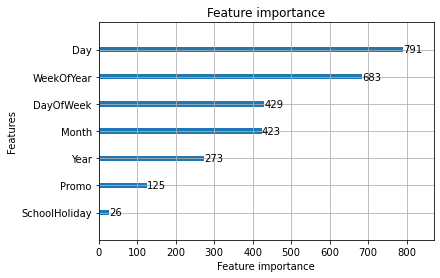

In [ ]:
lightgbm.plot_importance(lgbm)